# Deblur Images
### Columbia University APMAE4990 Final Project 
**Group Member**: Shan Guan (sg3506), Yiyi Zhang (yz3280), Yilin Lyu (yl3832), and Liangliang Huang (lh2863)  
[*Link to GitHub*](https://github.com/yiyi-zhang-cu/PROJECT-Deblur_Images)  

--------------------------------------------------------------------------------------------------------------------------------

## Table of Contents    <a name="ToC"></a>
* [Introduction](#Intro)
* [Model Implementation - DeblurGAN](#DeblurGAN)
    * [The GAN Model Architecture](#GAN)
    * [Staging](#Staging)
    * [Train Model (Demo)](#Train)
    * [Test Model](#Test)
* [Model Implementation - Deep Generative Filter](#DGF)
* [Model Evaluation](#Evaluation)
* [Debluring Customized Data](#App)

## Introduction <a name="Intro"></a>

In this notebook, we will implement and evaluate two image deblurring methods based on GANs introduced in [DeblurGAN: Blind Motion Deblurring Using Conditional Adversarial Networks](https://arxiv.org/pdf/1711.07064.pdf) and [Deep Generative Filter for Motion Deblurring](https://arxiv.org/pdf/1709.03481.pdf). We will select the better model and utilize it to build a web application for image debluring. 

#### Our Tasks 
**Implementation** of DeblurGAN in Tensorflow to deblur images;

**Comparison and explanations** of different models with different loss functions (lambda, partition);

**Sensitivity** of different pretrained models when calculating the content loss;

**Exploration** of different training procedures to save time;

Quantitative and visual **Evaluation** of the generalization and improvement of the trained model

## Model Implementation - DeblurGAN <a name="DeblurGAN"></a>

### The GAN Model Architecture <a name="GAN"></a>
**Generator network: ** *(ResNet)*

Input: blurred images; 

Output: the estimates of the sharp images (Deblured images)

**Discriminator networks: ** *(Multilayer perceptron)*

During the training time, the critic network takes restored and sharp image as an input and estimates a distance between them.

Loss Function: The total loss consists of WGAN loss from critic and perceptual loss 

<img src='./images/ipynb_images/total_loss.png'>

<img src='./images/ipynb_images/model_arc.png'>

### Staging <a name="Staging"></a>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import tensorflow as tf
from __future__ import print_function
import numpy as np
from model_tf import deblur_model
import argparse
from utils import load_images, load_own_images, deprocess_image, preprocess_image
import os
import h5py
import matplotlib.pyplot as plt
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
parser = argparse.ArgumentParser(description="deblur train")
parser.add_argument("--g_input_size", help="Generator input size of the image", default=256,type=int)
parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels')
parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in first conv layer')
parser.add_argument('--n_downsampling', type=int, default=2, help='# of downsampling in generator')
parser.add_argument('--n_blocks_gen', type=int, default=9, help='# of res block in generator')
parser.add_argument('--d_input_size', type=int, default=256, help='Generator input size')
parser.add_argument('--kernel_size', type=int, default=4, help='kernel size factor in discriminator')
parser.add_argument('--n_layers_D', type=int, default=3, help='only used if which_model_netD==n_layers')
parser.add_argument('--LAMBDA_A', default=100000, type=int, help='The lambda for preceptual loss')
parser.add_argument('--g_train_num', default=0, type=int, help='Train the generator for x epoch before adding discriminator')

param = parser.parse_args(args='')
tf.reset_default_graph()
model = deblur_model(param)

###  Train Model (Demo) <a name="Train"></a>

In [3]:
image_dir = './images'
train_data=load_images(os.path.join(image_dir, "train"), n_images=-1)

In [6]:
# The model training here only uses a small dataset which including 24 pictures,
# To train the full model please use the full GoPro dataset
# To manage data, see the README.md
model.train(train_data, 
            batch_size=2, 
            pre_trained_model=None, 
            save_freq = 200,
            epoch_num = 10,
            generate_image_freq = 50)

10/12 batch in 1/10 epochs, discriminator loss: 3.8570871353149414, generator loss: 0.9310964941978455
8/12 batch in 2/10 epochs, discriminator loss: 2.2369067668914795, generator loss: 0.6646406054496765
6/12 batch in 3/10 epochs, discriminator loss: 2.4102823734283447, generator loss: 0.4835439920425415
4/12 batch in 4/10 epochs, discriminator loss: 1.2434515953063965, generator loss: 0.472316175699234
2/12 batch in 5/10 epochs, discriminator loss: 0.9978889226913452, generator loss: 0.4795484244823456
image saved to deblur_train/Deblur_1525878301
12/12 batch in 5/10 epochs, discriminator loss: 1.370950698852539, generator loss: 0.3241066336631775
10/12 batch in 6/10 epochs, discriminator loss: 1.3270421028137207, generator loss: 0.3065028488636017
8/12 batch in 7/10 epochs, discriminator loss: 0.8592190742492676, generator loss: 0.3730468451976776
6/12 batch in 8/10 epochs, discriminator loss: 0.8049578070640564, generator loss: 0.3833147883415222
4/12 batch in 9/10 epochs, discrimi

#### Above showed a demo of training process. The following plot is the losses of full trained model. 

<img src='./images/ipynb_images/losses.png'>

### Test Model <a name="Test"></a>

In [7]:
# Set numbers of images to test 
test_data = load_images(os.path.join(image_dir, "test"), n_images=200)

In [8]:
# please replace your model name
model_name='Deblur_1525567719'
test_deblured_img = model.generate(test_data, batch_size=2, trained_model=model_name, save=False)

Load the model from: Deblur_1525567719
INFO:tensorflow:Restoring parameters from model/Deblur_1525567719
Model restored.
PSNR of testing data: 26.76833729496825


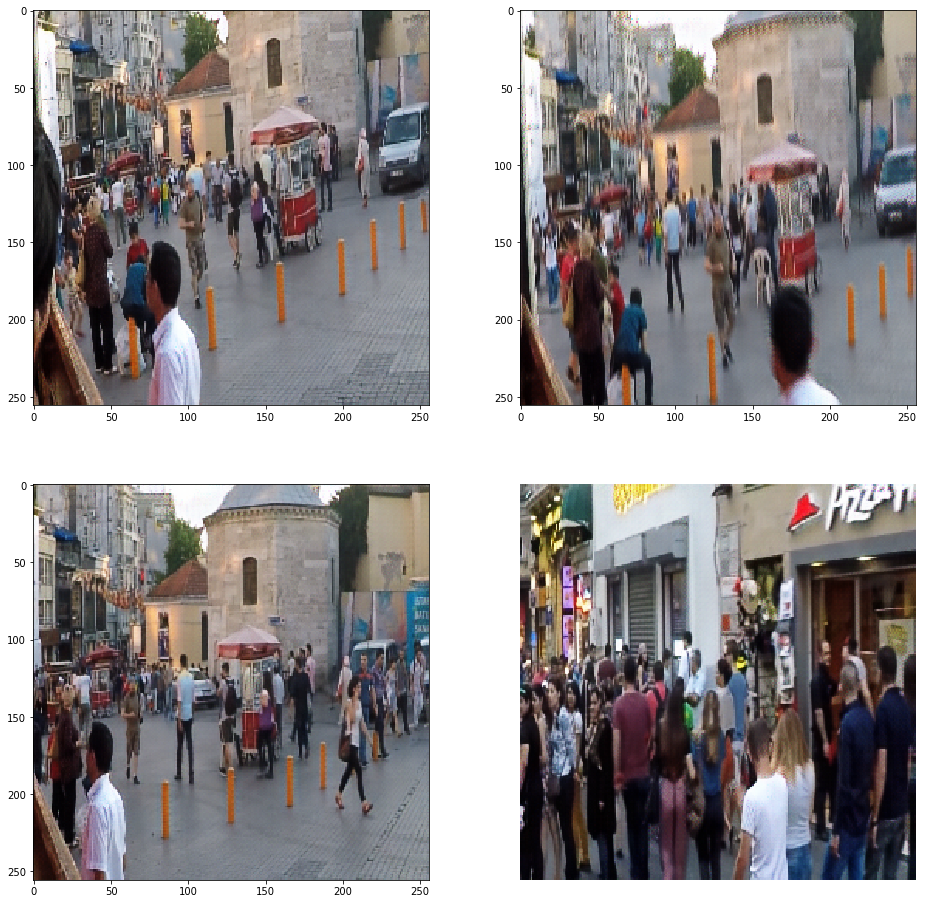

In [9]:
num_show = 4
mask = np.random.choice(test_deblured_img.shape[0], num_show, replace=False)
X_show = test_deblured_img[mask,:,:,:]
r = 2
f, axarr = plt.subplots(r, r, figsize=(16,16))
plt.axis("off")
for i in range(r):
    for j in range(r):
        #print(image.shape)
        image = X_show[r*i+j]
        axarr[i][j].imshow(image)

Note that the testing process was done by running in console instead of ipynb.  We tuned the hyperparameters of the model to present the greatest deblurring result. Details were saved in the file **model_log.txt**. 

## Model Implementation - Deep Generative Filter <a name="DGF"></a>

We tried another model for comparation. Details not showed here. 

## Model Evaluation <a name="Evaluation"></a>

We have used the [peak signal-to-noise ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric to evaluate the two models. The greater of PSNR, the better of debluring result. As the result shown below, the model proposed by the Deblur GAN paper performs better. The better model has been saved and will be used to build our web application. 

<img src='./images/ipynb_images/eva.png'>

Below is a visual evaluation of the optimal model on the testing data. From left to right are the sharp images, blurred images, and deblurred images respectively. 

<img src='./images/ipynb_images/6440_0.png'>

<img src='./images/ipynb_images/3800_0.png'>

## Debluring Customized Data <a name="App"></a>

In [7]:
image_dir = './images'
customized_data = load_own_images(os.path.join(image_dir, "own"), n_images=-1)
customized_data.shape

(7, 720, 1280, 3)

In [ ]:
# please replace your model name
model_name = 'Deblur_1525567719'
customized_deblured_img = model.generate(customized_data,
                                         batch_size=1, 
                                         trained_model=model_name, 
                                         customized=True,
                                         save=False)

In [9]:
img_show = np.concatenate((customized_deblured_img, deprocess_image(customized_data)), axis=1)

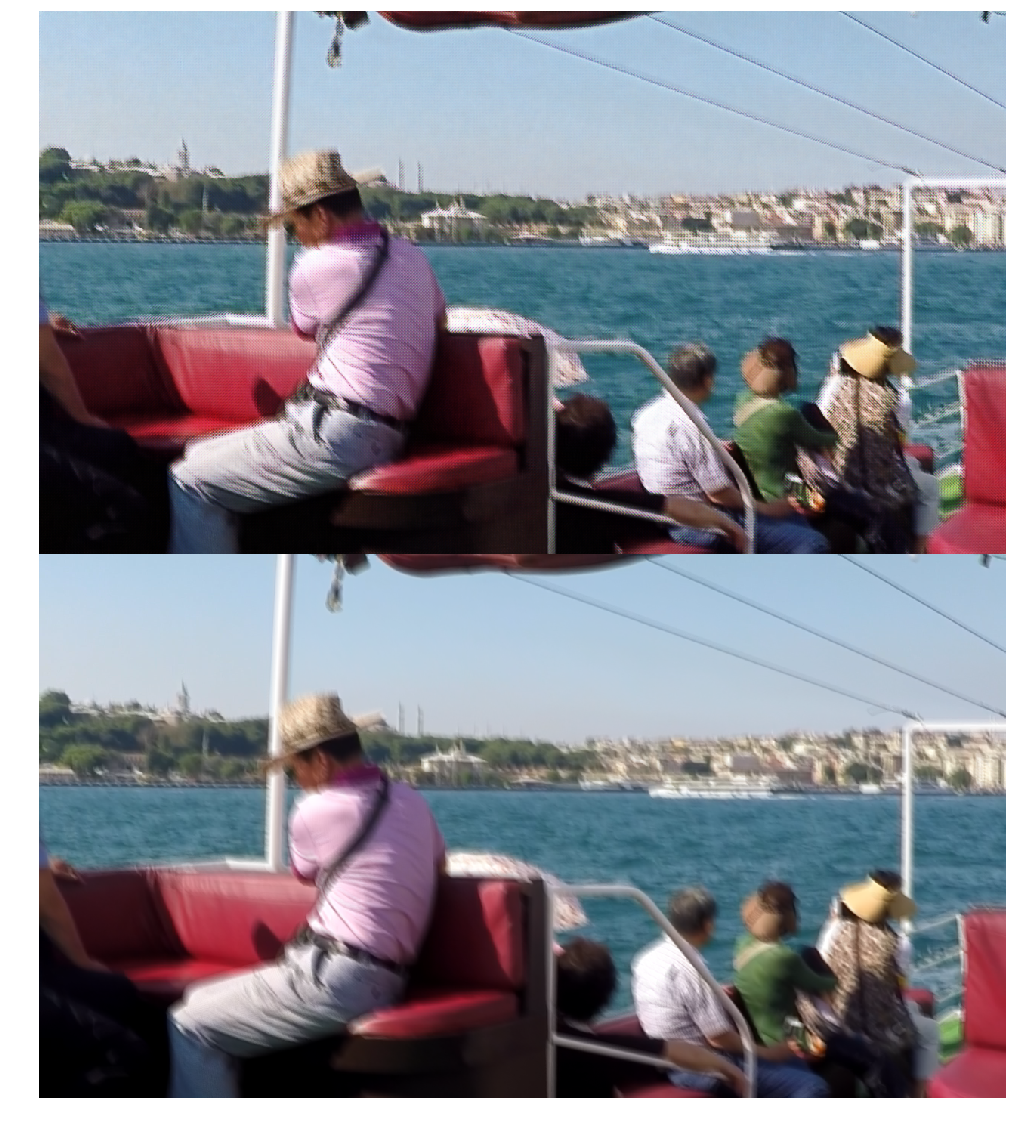

In [10]:
plt.figure(figsize = (20,20))
plt.axis("off")
plt.imshow(img_show[0])
plt.show()

Above shows the result of applying our optimal model on a blurry image. The top is the deblured image and the bottom is the original blurry image. 